# Common Neighbor Rule in PyC Subgraph (Th=0)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.visualization import *
from utils.common_neighbor_rule import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th0 = get_thresholded_graph(g_actual, axls, 0)
print(nx.info(g_th0))

Name: 
Type: DiGraph
Number of nodes: 227
Number of edges: 1257
Average in degree:   5.5374
Average out degree:   5.5374


### 2. Common Neighbor Rule (OBS vs ER vs CFG)

In [6]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_th0)

CPU times: user 892 ms, sys: 12 ms, total: 904 ms
Wall time: 899 ms


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [7]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,13796.0,23319.0,17698.0,276.0,863.0,679.0,852.0,661.0,11.0,18.0,0.020006,0.037008,0.038366
1,6525.0,1355.0,5978.0,322.0,161.0,384.0,150.0,374.0,11.0,10.0,0.049349,0.118819,0.064236
2,2806.0,568.0,1521.0,229.0,106.0,110.0,97.0,108.0,9.0,2.0,0.081611,0.186620,0.072321
3,1292.0,229.0,369.0,146.0,39.0,40.0,39.0,39.0,0.0,1.0,0.113003,0.170306,0.108401
4,601.0,86.0,69.0,104.0,21.0,9.0,21.0,9.0,0.0,0.0,0.173045,0.244186,0.130435
5,294.0,46.0,13.0,55.0,17.0,4.0,17.0,4.0,0.0,0.0,0.187075,0.369565,0.307692
6,151.0,25.0,3.0,29.0,11.0,0.0,11.0,0.0,0.0,0.0,0.192053,0.440000,0.000000
7,90.0,13.0,0.0,26.0,3.0,0.0,3.0,0.0,0.0,0.0,0.288889,0.230769,0.000000
8,40.0,4.0,0.0,15.0,2.0,0.0,2.0,0.0,0.0,0.0,0.375000,0.500000,0.000000
9,56.0,6.0,0.0,24.0,3.0,0.0,3.0,0.0,0.0,0.0,0.428571,0.500000,0.000000


In [8]:
%%time
# sample graphs from CFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_th0, samples=s, niters=int(1e4))
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)


CPU times: user 1min 51s, sys: 196 ms, total: 1min 51s
Wall time: 1min 51s


In [9]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats.to_csv("saved/th0_cnr_cfg100.csv", index=False)
cfg_cnr_stats_std.to_csv("saved/th0_cnrstd_cfg100.csv", index=False)

In [10]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats = pd.read_csv("saved/th0_cnr_cfg100.csv")
cfg_cnr_stats_std = pd.read_csv("saved/th0_cnrstd_cfg100.csv")

In [11]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,12092.33,21719.07,16053.59,301.93,874.92,711.40,867.92,698.98,7.00,12.42,0.024967,0.040283,0.044314
1,6555.54,1385.61,6072.42,318.67,175.91,370.67,169.34,363.22,6.57,7.45,0.048601,0.126945,0.061039
2,2887.21,574.96,1540.57,235.41,92.28,116.19,88.30,114.08,3.98,2.11,0.081532,0.160486,0.075386
3,1317.39,232.67,337.21,154.24,45.67,28.55,43.68,27.93,1.99,0.62,0.117053,0.196196,0.084513
4,627.81,95.75,69.72,94.39,21.54,6.13,20.14,6.09,1.40,0.04,0.150326,0.224551,0.087118
5,302.46,41.45,13.36,55.18,11.15,1.24,10.44,1.24,0.71,0.00,0.182237,0.269496,0.093202
6,149.92,19.69,2.60,31.84,5.81,0.16,5.44,0.16,0.37,0.00,0.211548,0.296251,0.055000
7,74.83,9.69,0.48,18.46,3.18,0.02,2.95,0.02,0.23,0.00,0.246454,0.325660,0.013333
8,37.89,5.08,0.05,10.35,1.94,0.00,1.78,0.00,0.16,0.00,0.271963,0.383715,0.000000
9,44.62,6.03,0.00,13.89,1.96,0.00,1.73,0.00,0.23,0.00,0.305852,0.329107,0.000000


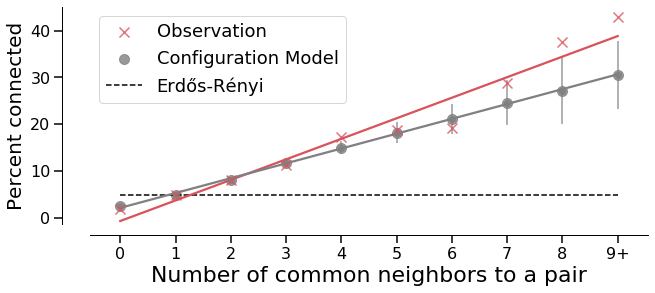

In [12]:
# plot CNR curves
E, N = len(g_th0.edges), len(g_th0.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="th0/th0_cnr")

In [13]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.9490106748012874, 1.887255915968165e-06)

In [14]:
# Pearson r^2 and p-value for CFG
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9991106174591414, 1.7114611044699392e-13)

### 3. Common Neighbor Rule (OBS vs gER vs gCFG)

In [15]:
%%time
# sample graphs from gCFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_th0, samples=s, niters=int(1e4))
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)


CPU times: user 2min 9s, sys: 56 ms, total: 2min 9s
Wall time: 2min 9s


In [16]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats_GE.to_csv("saved/th0_cnr_gcfg100.csv", index=False)
cfg_cnr_stats_std_GE.to_csv("saved/th0_cnrstd_gcfg100.csv", index=False)

In [17]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats_GE = pd.read_csv("saved/th0_cnr_gcfg100.csv")
cfg_cnr_stats_std_GE = pd.read_csv("saved/th0_cnrstd_gcfg100.csv")

In [18]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,12162.91,21742.21,16156.11,309.81,875.48,721.12,865.61,703.85,9.87,17.27,0.025472,0.040266,0.044634
1,6577.05,1379.48,6029.53,321.10,175.07,360.92,166.73,350.96,8.34,9.96,0.048822,0.126912,0.059858
2,2876.37,568.80,1495.38,234.82,89.12,111.33,83.19,108.34,5.93,2.99,0.081641,0.156692,0.074435
3,1293.61,226.44,325.80,151.05,42.06,26.14,39.05,25.47,3.01,0.67,0.116746,0.185735,0.080319
4,608.73,93.15,66.18,90.49,21.43,5.19,19.86,5.11,1.57,0.08,0.148651,0.230054,0.078043
5,288.93,40.29,13.46,51.27,10.68,1.04,9.74,1.01,0.94,0.03,0.177343,0.263495,0.074809
6,140.30,19.18,2.90,29.84,5.64,0.20,5.07,0.20,0.57,0.00,0.212194,0.294740,0.072429
7,68.35,10.27,0.50,16.52,3.08,0.04,2.76,0.04,0.32,0.00,0.241404,0.303814,0.033333
8,34.64,4.46,0.13,9.24,1.56,0.02,1.37,0.02,0.19,0.00,0.265557,0.351980,0.020000
9,39.11,5.72,0.01,11.86,1.88,0.00,1.62,0.00,0.26,0.00,0.299558,0.324005,0.000000


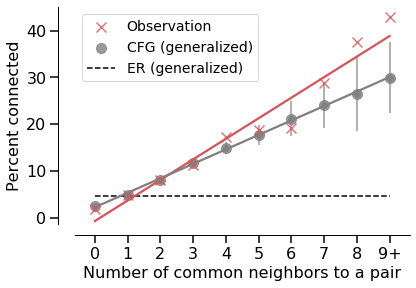

In [19]:
# plot CNR curves
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th0)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), cfg_name="CFG (generalized)", er_name="ER (generalized)", fname="th0/th0_cnr_GE")

### 4. Generate Small Plots for Panels (OBS vs gER vs CFG)

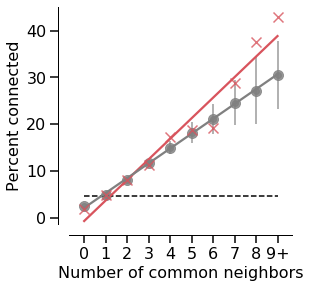

In [20]:
plot_cnr_adapt(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, 
         figsize=(4,4), fontsizes=(16, 16, 16, 14), fname="th0/th0_cnr_CGE")